# Pre-processing Delaware Riber Basin Commission Aggregated Amounts data for WaDE upload.
Date Updated: 08/29/2023
Purpose:  To pre-process the ND data into one master file for simple DataFrame creation and extraction

In [1]:
#Needed Libararies

# working with data
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import math

# visulizaiton
import matplotlib.pyplot as plt
import seaborn as sns

# API retrieval
import requests
import json

# Cleanup
import re
from datetime import datetime
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x) # suppress scientific notation in Pandas

In [2]:
# Working Directory
workingDir = "G:/Shared drives/WaDE Data/WaDE Data Folder/NorthDakota/WaterUse_AggregatedArea"
os.chdir(workingDir)
print(os.getcwd())

G:\Shared drives\WaDE Data\WaDE Data Folder\NorthDakota\WaterUse_AggregatedArea


## Input Source Data

In [3]:
# timeseries data, xlsx file
dfA1 ="RawInputData/WATER USE REPORT_Basin_use_20230829_All.zip"
df1 = pd.read_csv(dfA1, encoding = "ISO-8859-1").replace(np.nan, "")

# Drop duplicates
dfIn = df1.drop_duplicates().reset_index(drop=True).replace(np.nan, "")

# WaDE UUID tracker for data assessment
if 'WaDEUUID' not in dfIn:
    dfIn['WaDEUUID'] = "ndag" + dfIn.index.astype(str)
    dfIn.to_csv('WATER USE REPORT_Basin_use_20230829_All.zip', compression=dict(method='zip', archive_name='WATER USE REPORT_Basin_use_20230829_All.csv'), index=False)

print(len(dfIn))
dfIn.head()

7605


,Ã¯Â»Â¿Basin,Use Type,Year,Acre Feet,Acres,WaDEUUID
0,Apple Creek,Domestic,Year,Acre Feet,Acres,drbc0
1,,,1984,0,0,drbc1
2,,,1983,0,0,drbc2
3,,,1981,0,0,drbc3
4,,,1977,0,0,drbc4


In [4]:
# Loop through each column filling out the basin and use type fields that are missing

def basinAdd(dfIn):
    # Iterate through each column
    for col in dfIn.columns:
        prev_value = None

        # Iterate through each row
        for index, value in dfIn[col].items():
            if value == "":
                if prev_value is not None:
                    dfIn.at[index, col] = prev_value
            else:
                prev_value = value

    return dfIn

dfIn = basinAdd(dfIn.copy())
print(len(dfIn))
dfIn.head()

7605


,Ã¯Â»Â¿Basin,Use Type,Year,Acre Feet,Acres,WaDEUUID
0,Apple Creek,Domestic,Year,Acre Feet,Acres,drbc0
1,Apple Creek,Domestic,1984,0,0,drbc1
2,Apple Creek,Domestic,1983,0,0,drbc2
3,Apple Creek,Domestic,1981,0,0,drbc3
4,Apple Creek,Domestic,1977,0,0,drbc4


In [5]:
#dropping the rows that have the column names
dfIn = dfIn[dfIn['Acres'] != 'Acres']
print(len(dfIn))
dfIn.head(1)

7316


,Ã¯Â»Â¿Basin,Use Type,Year,Acre Feet,Acres,WaDEUUID
1,Apple Creek,Domestic,1984,0,0,drbc1


In [6]:
# shapefile info
# we only want the stuff that is related to ND.

gdf_drb147 = gpd.read_file('RawInputData/shapefile/NDGISHUB_HUC8_Subbasin.zip', crs="EPSG:4326")
gdf_drb147 = gdf_drb147[gdf_drb147['STATES'].str.contains('ND', na=False)]
print(len(gdf_drb147))
gdf_drb147.head(1)

55


,OBJECTID,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,AREASQKM,AREAACRES,GNIS_ID,NAME,STATES,HUC8,SHAPE_Leng,SHAPE_Area,geometry
4,603,{60B27A0F-BF39-4521-828F-AC46265EE818},None,None,None,None,2017-10-12,4490.00000,1109503.04000,None,Long Creek,"CN,ND",09010006,7.73751,0.55334,"POLYGON ((-104.42949 49.65328, -104.42913 49.6..."


In [7]:
# left merge timeseries info with shapefile info.
dfIn2 = pd.DataFrame()
dfIn2 = pd.merge(dfIn, gdf_drb147, left_on='Ã¯Â»Â¿Basin', right_on = 'NAME')
dfIn2 = dfIn2.drop_duplicates().replace(np.nan, "").replace("nan,nan", "").reset_index(drop=True)
print(len(dfIn2))
dfIn2.head()

7486


,Ã¯Â»Â¿Basin,Use Type,Year,Acre Feet,Acres,WaDEUUID,OBJECTID,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,AREASQKM,AREAACRES,GNIS_ID,NAME,STATES,HUC8,SHAPE_Leng,SHAPE_Area,geometry
0,Apple Creek,Domestic,1984,0,0,drbc1,618,{5E41D692-5B49-4F65-AADA-5DFBF7C12167},,,,,2012-06-11,9411.15000,2325544.70000,,Apple Creek,ND,10130103,7.81853,1.11013,"POLYGON ((-100.04608 47.43855, -100.04570 47.4..."
1,Apple Creek,Domestic,1983,0,0,drbc2,618,{5E41D692-5B49-4F65-AADA-5DFBF7C12167},,,,,2012-06-11,9411.15000,2325544.70000,,Apple Creek,ND,10130103,7.81853,1.11013,"POLYGON ((-100.04608 47.43855, -100.04570 47.4..."
2,Apple Creek,Domestic,1981,0,0,drbc3,618,{5E41D692-5B49-4F65-AADA-5DFBF7C12167},,,,,2012-06-11,9411.15000,2325544.70000,,Apple Creek,ND,10130103,7.81853,1.11013,"POLYGON ((-100.04608 47.43855, -100.04570 47.4..."
3,Apple Creek,Domestic,1977,0,0,drbc4,618,{5E41D692-5B49-4F65-AADA-5DFBF7C12167},,,,,2012-06-11,9411.15000,2325544.70000,,Apple Creek,ND,10130103,7.81853,1.11013,"POLYGON ((-100.04608 47.43855, -100.04570 47.4..."
4,Apple Creek,Fish and Wildlife,1990,0.1,0,drbc6,618,{5E41D692-5B49-4F65-AADA-5DFBF7C12167},,,,,2012-06-11,9411.15000,2325544.70000,,Apple Creek,ND,10130103,7.81853,1.11013,"POLYGON ((-100.04608 47.43855, -100.04570 47.4..."


## Convert to WaDE Input Data

In [8]:
dfIn2.head()

,Ã¯Â»Â¿Basin,Use Type,Year,Acre Feet,Acres,WaDEUUID,OBJECTID,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,AREASQKM,AREAACRES,GNIS_ID,NAME,STATES,HUC8,SHAPE_Leng,SHAPE_Area,geometry
0,Apple Creek,Domestic,1984,0,0,drbc1,618,{5E41D692-5B49-4F65-AADA-5DFBF7C12167},,,,,2012-06-11,9411.15000,2325544.70000,,Apple Creek,ND,10130103,7.81853,1.11013,"POLYGON ((-100.04608 47.43855, -100.04570 47.4..."
1,Apple Creek,Domestic,1983,0,0,drbc2,618,{5E41D692-5B49-4F65-AADA-5DFBF7C12167},,,,,2012-06-11,9411.15000,2325544.70000,,Apple Creek,ND,10130103,7.81853,1.11013,"POLYGON ((-100.04608 47.43855, -100.04570 47.4..."
2,Apple Creek,Domestic,1981,0,0,drbc3,618,{5E41D692-5B49-4F65-AADA-5DFBF7C12167},,,,,2012-06-11,9411.15000,2325544.70000,,Apple Creek,ND,10130103,7.81853,1.11013,"POLYGON ((-100.04608 47.43855, -100.04570 47.4..."
3,Apple Creek,Domestic,1977,0,0,drbc4,618,{5E41D692-5B49-4F65-AADA-5DFBF7C12167},,,,,2012-06-11,9411.15000,2325544.70000,,Apple Creek,ND,10130103,7.81853,1.11013,"POLYGON ((-100.04608 47.43855, -100.04570 47.4..."
4,Apple Creek,Fish and Wildlife,1990,0.1,0,drbc6,618,{5E41D692-5B49-4F65-AADA-5DFBF7C12167},,,,,2012-06-11,9411.15000,2325544.70000,,Apple Creek,ND,10130103,7.81853,1.11013,"POLYGON ((-100.04608 47.43855, -100.04570 47.4..."


In [9]:
# Withdrawal dataframe
# --------------------------

# create output POD dataframe
df = pd.DataFrame()

# Data Assessment UUID
df['WaDEUUID'] = dfIn2['WaDEUUID']

# Method Info
df['in_MethodUUID'] = "NDag_M1"

# Variable Info
df['in_VariableSpecificUUID'] = "" # determine below
df['in_AggregationIntervalUnitCV'] = "Annual"
df['in_VariableCV'] = "Withdrawal"
df['in_VariableSpecificCV'] = "" # determine below

# Organization Info
df['in_OrganizationUUID'] = "NDag_O1"

# Water Source
df['in_Geometry'] = ""
df['in_GNISFeatureNameCV'] = ""
df['in_WaterQualityIndicatorCV'] = ""
df["in_WaterSourceName"] = ""
df['in_WaterSourceNativeID'] = ""
df["in_WaterSourceTypeCV"] = "Surface and Groundwater"

# ReportingUnits Info
df['in_EPSGCodeCV'] = 4326
df['in_ReportingUnitName'] = dfIn2['Ã¯Â»Â¿Basin']
df['in_ReportingUnitNativeID'] = "nd" +dfIn2['HUC8'].replace("", 0).fillna(0).astype(str).str.strip()
df['in_ReportingUnitProductVersion'] = ""
df['in_ReportingUnitTypeCV'] = "HUC8"
df['in_ReportingUnitUpdateDate'] = ""
df['in_StateCV'] = "ND"

# AggregatedAmounts Info
df['in_AllocationCropDutyAmount'] = ""
df['in_Amount'] = dfIn2['Acre Feet']
df['in_BeneficialUseCategory'] = dfIn2['Use Type']
df['in_CommunityWaterSupplySystem'] = ""
df['in_CropTypeCV'] = ""
df['in_CustomerTypeCV'] = ""
df['in_DataPublicationDate'] = ""
df['in_DataPublicationDOI'] = ""
df['in_InterbasinTransferFromID'] = ""
df['in_InterbasinTransferToID'] = ""
df['in_IrrigatedAcreage'] = dfIn2['Acres']
df['in_IrrigationMethodCV'] = ""
df['in_PopulationServed'] = ""
df['in_PowerGeneratedGWh'] = ""
df['in_PowerType'] = ""
df['in_PrimaryUseCategoryCV'] = ""
df['in_ReportYearCV'] = dfIn2['Year']
df['in_SDWISIdentifierCV'] = ""
df['in_TimeframeEnd'] = "12/31/" + dfIn2['Year'] # determine below
df['in_TimeframeStart'] = "01/01/" + dfIn2['Year']  # determine below

outdf = df.copy()
outdf = outdf.drop_duplicates().reset_index(drop=True)
print(len(outdf))
outdf.head(5)

7486


,WaDEUUID,in_MethodUUID,in_VariableSpecificUUID,in_AggregationIntervalUnitCV,in_VariableCV,in_VariableSpecificCV,in_OrganizationUUID,in_Geometry,in_GNISFeatureNameCV,in_WaterQualityIndicatorCV,in_WaterSourceName,in_WaterSourceNativeID,in_WaterSourceTypeCV,in_EPSGCodeCV,in_ReportingUnitName,in_ReportingUnitNativeID,in_ReportingUnitProductVersion,in_ReportingUnitTypeCV,in_ReportingUnitUpdateDate,in_StateCV,in_AllocationCropDutyAmount,in_Amount,in_BeneficialUseCategory,in_CommunityWaterSupplySystem,in_CropTypeCV,in_CustomerTypeCV,in_DataPublicationDate,in_DataPublicationDOI,in_InterbasinTransferFromID,in_InterbasinTransferToID,in_IrrigatedAcreage,in_IrrigationMethodCV,in_PopulationServed,in_PowerGeneratedGWh,in_PowerType,in_PrimaryUseCategoryCV,in_ReportYearCV,in_SDWISIdentifierCV,in_TimeframeEnd,in_TimeframeStart
0,drbc1,NDag_M1,,Annual,Withdrawal,,NDag_O1,,,,,,Surface and Groundwater,4326,Apple Creek,nd10130103,,HUC8,,ND,,0,Domestic,,,,,,,,0,,,,,,1984,,12/31/1984,01/01/1984
1,drbc2,NDag_M1,,Annual,Withdrawal,,NDag_O1,,,,,,Surface and Groundwater,4326,Apple Creek,nd10130103,,HUC8,,ND,,0,Domestic,,,,,,,,0,,,,,,1983,,12/31/1983,01/01/1983
2,drbc3,NDag_M1,,Annual,Withdrawal,,NDag_O1,,,,,,Surface and Groundwater,4326,Apple Creek,nd10130103,,HUC8,,ND,,0,Domestic,,,,,,,,0,,,,,,1981,,12/31/1981,01/01/1981
3,drbc4,NDag_M1,,Annual,Withdrawal,,NDag_O1,,,,,,Surface and Groundwater,4326,Apple Creek,nd10130103,,HUC8,,ND,,0,Domestic,,,,,,,,0,,,,,,1977,,12/31/1977,01/01/1977
4,drbc6,NDag_M1,,Annual,Withdrawal,,NDag_O1,,,,,,Surface and Groundwater,4326,Apple Creek,nd10130103,,HUC8,,ND,,0.1,Fish and Wildlife,,,,,,,,0,,,,,,1990,,12/31/1990,01/01/1990


## WaDE Custom Elements (due to missing sate info)

In [10]:
# Clean owner name up
def removeSpecialCharsFunc(Val):
    Val = str(Val)
    Val = re.sub("[$@&.;,/\)(-]", "", Val).title().replace(" ", "").strip()
    return Val

<>:4: SyntaxWarning: invalid escape sequence '\)'
<>:4: SyntaxWarning: invalid escape sequence '\)'
C:\Users\rjame\AppData\Local\Temp\ipykernel_16928\3258504652.py:4: SyntaxWarning: invalid escape sequence '\)'
  Val = re.sub("[$@&.;,/\)(-]", "", Val).title().replace(" ", "").strip()


In [11]:
outdf['in_ReportingUnitName'] = outdf.apply(lambda row: removeSpecialCharsFunc(row['in_ReportingUnitName']), axis=1)
outdf['in_ReportingUnitName'].unique()

array(['AppleCreek', 'Beaver', 'BigMuddy', 'BoisDeSioux', 'Boxelder',
       'BrushLakeClosedBasin', 'Cedar', 'CharlielittleMuddy', 'Deep',
       'DesLacs', 'DevilsLake', 'Elm', 'Elmmarsh', 'Forest', 'Goose',
       'Grand', 'GrandMaraisred', 'HeadwatersSourisRiver',
       'JamesHeadwaters', 'Knife', 'LakeSakakawea', 'LittleMuddy',
       'LongCreek', 'LowerCannonball', 'LowerHeart',
       'LowerLittleMissouri', 'LowerPembinaRiver', 'LowerSheyenne',
       'LowerSouris', 'LowerYellowstone', 'Maple', 'MiddleLittleMissouri',
       'MiddleRed', 'MiddleSheyenne', 'MooseMountainCreeksourisRiver',
       'NorthForkGrand', 'PaintedWoodssquareButte', 'Park', 'Pipestem',
       'Sandhillwilson', 'Turtle', 'UpperCannonball', 'UpperHeart',
       'UpperJames', 'UpperLakeOahe', 'UpperLittleMissouri',
       'UpperPembinaRiver', 'UpperRed', 'UpperSheyenne',
       'WestMissouriCoteau', 'WesternWildRice', 'Willow'], dtype=object)

In [12]:
outdf['in_WaterSourceName'] = outdf.apply(lambda row: removeSpecialCharsFunc(row['in_WaterSourceName']), axis=1)
outdf['in_WaterSourceName'].unique()

array([''], dtype=object)

In [13]:
def ensureEmptyString(val):
    val = str(val).strip()
    if val == "" or val == " " or val == "nan" or pd.isnull(val):
        outString = ""
    else:
        outString = val
    return outString

In [14]:
outdf['in_WaterSourceName'] = outdf.apply(lambda row: ensureEmptyString(row['in_WaterSourceName']), axis=1)
outdf['in_WaterSourceName'].unique()

array([''], dtype=object)

In [15]:
outdf['in_WaterSourceTypeCV'] = outdf.apply(lambda row: ensureEmptyString(row['in_WaterSourceTypeCV']), axis=1)
outdf['in_WaterSourceTypeCV'].unique()

array(['Surface and Groundwater'], dtype=object)

In [16]:
outdf['in_ReportingUnitName'] = outdf.apply(lambda row: ensureEmptyString(row['in_ReportingUnitName']), axis=1)
outdf['in_ReportingUnitName'].unique()

array(['AppleCreek', 'Beaver', 'BigMuddy', 'BoisDeSioux', 'Boxelder',
       'BrushLakeClosedBasin', 'Cedar', 'CharlielittleMuddy', 'Deep',
       'DesLacs', 'DevilsLake', 'Elm', 'Elmmarsh', 'Forest', 'Goose',
       'Grand', 'GrandMaraisred', 'HeadwatersSourisRiver',
       'JamesHeadwaters', 'Knife', 'LakeSakakawea', 'LittleMuddy',
       'LongCreek', 'LowerCannonball', 'LowerHeart',
       'LowerLittleMissouri', 'LowerPembinaRiver', 'LowerSheyenne',
       'LowerSouris', 'LowerYellowstone', 'Maple', 'MiddleLittleMissouri',
       'MiddleRed', 'MiddleSheyenne', 'MooseMountainCreeksourisRiver',
       'NorthForkGrand', 'PaintedWoodssquareButte', 'Park', 'Pipestem',
       'Sandhillwilson', 'Turtle', 'UpperCannonball', 'UpperHeart',
       'UpperJames', 'UpperLakeOahe', 'UpperLittleMissouri',
       'UpperPembinaRiver', 'UpperRed', 'UpperSheyenne',
       'WestMissouriCoteau', 'WesternWildRice', 'Willow'], dtype=object)

In [17]:
outdf['in_ReportingUnitTypeCV'] = outdf.apply(lambda row: ensureEmptyString(row['in_ReportingUnitTypeCV']), axis=1)
outdf['in_ReportingUnitTypeCV'].unique()

array(['HUC8'], dtype=object)

In [18]:
outdf['in_BeneficialUseCategory'] = outdf.apply(lambda row: ensureEmptyString(row['in_BeneficialUseCategory']), axis=1)
for x in outdf['in_BeneficialUseCategory'].sort_values().unique():
    print(f'"' + x + '",')

"Commercial",
"Domestic",
"Fish and Wildlife",
"Flood Control",
"Industrial",
"Irrigation",
"Multiple Use",
"Municipal",
"Power Generation",
"Recreation",
"Rural Water",
"Stock",


In [19]:
# Fixing n_Amount datatype
outdf['in_Amount'] = pd.to_numeric(outdf['in_Amount'], errors='coerce').replace(0,"").fillna("")
outdf['in_Amount'].unique()

array(['', 0.1, 1695.0, ..., 450.3, 426.8, 193.2], dtype=object)

In [20]:
%%time

# Creating WaDE Custom water source native ID for easy water source identification
# ----------------------------------------------------------------------------------------------------

# Create temp WaterSourceNativeID dataframe of unique water source.
def assignWaterSourceNativeID(colrowValue):
    string1 = str(colrowValue)
    outstring = "wadeID" + string1
    return outstring

dfWaterSourceNativeID = pd.DataFrame()
dfWaterSourceNativeID['in_WaterSourceName'] = outdf['in_WaterSourceName']
dfWaterSourceNativeID['in_WaterSourceTypeCV'] = outdf['in_WaterSourceTypeCV']
dfWaterSourceNativeID = dfWaterSourceNativeID.drop_duplicates()

dftemp = pd.DataFrame(index=dfWaterSourceNativeID.index)
dftemp["Count"] = range(1, len(dftemp.index) + 1)
dfWaterSourceNativeID['in_WaterSourceNativeID'] = dftemp.apply(lambda row: assignWaterSourceNativeID(row['Count']), axis=1)
dfWaterSourceNativeID['linkKey'] = dfWaterSourceNativeID['in_WaterSourceName'].astype(str).str.strip() + dfWaterSourceNativeID['in_WaterSourceTypeCV'].astype(str).str.strip()

# ----------------------------------------------------------------------------------------------------

# Retreive WaDE Custom water source native ID
WaterSourceNativeIDdict = pd.Series(dfWaterSourceNativeID.in_WaterSourceNativeID.values, index=dfWaterSourceNativeID.linkKey.astype(str)).to_dict()
def retrieveWaterSourceNativeID(A, B):
    if (A == '' and B == '') or (pd.isnull(A) and pd.isnull(B)):
        outList = ''
    else:
        colrowValue = str(A).strip() + str(B).strip()
        try:
            outList = WaterSourceNativeIDdict[colrowValue]
        except:
            outList = ''
    return outList

outdf['in_WaterSourceNativeID'] = outdf.apply(lambda row: retrieveWaterSourceNativeID( row['in_WaterSourceName'], row['in_WaterSourceTypeCV']), axis=1)
outdf['in_WaterSourceNativeID'].unique()

CPU times: total: 78.1 ms
Wall time: 69.1 ms


array(['wadeID1'], dtype=object)

In [21]:
# determine in_VariableSpecificCV
outdf['in_VariableSpecificCV'] = outdf['in_VariableCV'].astype(str) + "_" + outdf['in_AggregationIntervalUnitCV'].astype(str) + "_" + outdf['in_BeneficialUseCategory'].astype(str) + "_" + outdf['in_WaterSourceTypeCV'].astype(str)
outdf['in_VariableSpecificCV'].unique()

array(['Withdrawal_Annual_Domestic_Surface and Groundwater',
       'Withdrawal_Annual_Fish and Wildlife_Surface and Groundwater',
       'Withdrawal_Annual_Industrial_Surface and Groundwater',
       'Withdrawal_Annual_Irrigation_Surface and Groundwater',
       'Withdrawal_Annual_Municipal_Surface and Groundwater',
       'Withdrawal_Annual_Recreation_Surface and Groundwater',
       'Withdrawal_Annual_Rural Water_Surface and Groundwater',
       'Withdrawal_Annual_Stock_Surface and Groundwater',
       'Withdrawal_Annual_Commercial_Surface and Groundwater',
       'Withdrawal_Annual_Multiple Use_Surface and Groundwater',
       'Withdrawal_Annual_Power Generation_Surface and Groundwater',
       'Withdrawal_Annual_Flood Control_Surface and Groundwater'],
      dtype=object)

In [22]:
%%time

# Creating WaDE VariableSpecificUUID for easy VariableSpecificCV identification 
# use these inputs: VariableCV_AggregationIntervalUnitCV_BeneficalUse_WaterSourceTypeCV
# ----------------------------------------------------------------------------------------------------

# Create temp VariableSpecificUUID dataframe of unique water source.
def assignVariableSpecificUUID(colrowValue):
    string1 = str(colrowValue)
    outstring = "NDag_V" + string1
    return outstring

dfVariableSpecificUUID = pd.DataFrame()
dfVariableSpecificUUID['in_VariableCV'] = outdf['in_VariableCV']
dfVariableSpecificUUID['in_AggregationIntervalUnitCV'] = outdf['in_AggregationIntervalUnitCV']
dfVariableSpecificUUID['in_BeneficialUseCategory'] = outdf['in_BeneficialUseCategory']
dfVariableSpecificUUID['in_WaterSourceTypeCV'] = outdf['in_WaterSourceTypeCV']
dfVariableSpecificUUID = dfVariableSpecificUUID.drop_duplicates()

dftemp = pd.DataFrame(index=dfVariableSpecificUUID.index)
dftemp["Count"] = range(1, len(dftemp.index) + 1)
dfVariableSpecificUUID['in_VariableSpecificUUID'] = dftemp.apply(lambda row: assignVariableSpecificUUID(row['Count']), axis=1)
dfVariableSpecificUUID['linkKey'] = dfVariableSpecificUUID['in_VariableCV'].astype(str) + dfVariableSpecificUUID['in_AggregationIntervalUnitCV'].astype(str) + dfVariableSpecificUUID['in_BeneficialUseCategory'].astype(str) + dfVariableSpecificUUID['in_WaterSourceTypeCV'].astype(str)

# ----------------------------------------------------------------------------------------------------

# Retreive WaDE Custom water source native ID
VariableSpecificUUIDdict = pd.Series(dfVariableSpecificUUID.in_VariableSpecificUUID.values, index=dfVariableSpecificUUID.linkKey.astype(str)).to_dict()
def retrieveVariableSpecificUUID(A, B, C, D):
    if (A == '' and B == '' and C == '' and D == '') or (pd.isnull(A) and pd.isnull(B) and pd.isnull(C) and pd.isnull(D)):
        outList = ''
    else:
        colrowValue = str(A).strip() + str(B).strip() + str(C).strip() + str(D).strip()
        try:
            outList = VariableSpecificUUIDdict[colrowValue]
        except:
            outList = ''
    return outList

outdf['in_VariableSpecificUUID'] = outdf.apply(lambda row: retrieveVariableSpecificUUID(row['in_VariableCV'], row['in_AggregationIntervalUnitCV'], row['in_BeneficialUseCategory'], row['in_WaterSourceTypeCV']), axis=1)
outdf['in_VariableSpecificUUID'].unique()

CPU times: total: 109 ms
Wall time: 99.4 ms


array(['NDag_V1', 'NDag_V2', 'NDag_V3', 'NDag_V4', 'NDag_V5', 'NDag_V6',
       'NDag_V7', 'NDag_V8', 'NDag_V9', 'NDag_V10', 'NDag_V11',
       'NDag_V12'], dtype=object)

## Shapefile Data
- For attaching geometry to csv inputs.

In [23]:
# PoU Shapefile Data
# Shapefile input
#dfshapetemp = gpd.read_file('shapefile//NDGISHUB_HUC8_Subbasin.zip', crs="EPSG:4326")
dfshapetemp = gdf_drb147.copy()
print(len(dfshapetemp))
dfshapetemp.head()

55


,OBJECTID,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,AREASQKM,AREAACRES,GNIS_ID,NAME,STATES,HUC8,SHAPE_Leng,SHAPE_Area,geometry
4,603,{60B27A0F-BF39-4521-828F-AC46265EE818},None,None,None,None,2017-10-12,4490.00000,1109503.04000,None,Long Creek,"CN,ND",09010006,7.73751,0.55334,"POLYGON ((-104.42949 49.65328, -104.42913 49.6..."
5,604,{37B5EFDB-88CF-4567-8878-1E30CB175960},None,None,None,None,2017-10-12,2724.59000,673261.09000,None,Brush Lake Closed Basin,"CN,MT,ND",10060007,4.39443,0.33417,"POLYGON ((-104.36249 49.24502, -104.36163 49.2..."
8,607,{81E696A2-DA41-4011-B798-BA059455D7FB},None,None,None,None,2017-10-12,8905.55000,2200607.34000,None,Big Muddy,"CN,MT,ND",10060006,8.17504,1.08872,"POLYGON ((-104.73156 49.45216, -104.73013 49.4..."
19,618,{5E41D692-5B49-4F65-AADA-5DFBF7C12167},None,None,None,None,2012-06-11,9411.15000,2325544.70000,None,Apple Creek,ND,10130103,7.81853,1.11013,"POLYGON ((-100.04608 47.43855, -100.04570 47.4..."
53,652,{7E21D7B9-94CD-4D9E-9257-CEF6209F9D43},None,None,None,None,2016-03-28,4649.35000,1148878.50000,None,Willow,"CN,ND",09010004,6.07881,0.56718,"POLYGON ((-100.13318 49.07945, -100.13277 49.0..."


<Axes: >

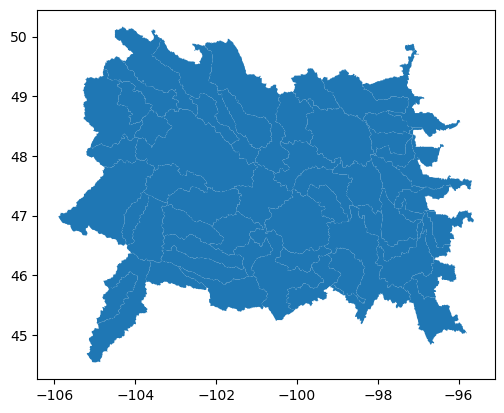

In [24]:
dfshapetemp.plot()

In [25]:
columnsList = ['in_ReportingUnitNativeID', 'geometry']
outshape = pd.DataFrame(columns=columnsList)
outshape['in_ReportingUnitNativeID'] = "nd" + dfshapetemp['HUC8'].replace("", 0).fillna(0).astype(str).str.strip()
outshape['geometry'] = dfshapetemp['geometry']
outshape = outshape.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
outshape.head(20)

,in_ReportingUnitNativeID,geometry
4,nd09010006,"POLYGON ((-104.42949 49.65328, -104.42913 49.6..."
5,nd10060007,"POLYGON ((-104.36249 49.24502, -104.36163 49.2..."
8,nd10060006,"POLYGON ((-104.73156 49.45216, -104.73013 49.4..."
19,nd10130103,"POLYGON ((-100.04608 47.43855, -100.04570 47.4..."
53,nd09010004,"POLYGON ((-100.13318 49.07945, -100.13277 49.0..."
54,nd09020316,"POLYGON ((-98.80805 49.45001, -98.80757 49.450..."
55,nd09020315,"POLYGON ((-99.70401 49.46936, -99.70399 49.469..."
57,nd10130101,"POLYGON ((-101.06776 47.89776, -101.06718 47.8..."
58,nd10130104,"POLYGON ((-99.34932 46.49049, -99.34879 46.490..."
59,nd10130201,"POLYGON ((-102.57498 47.48261, -102.57445 47.4..."


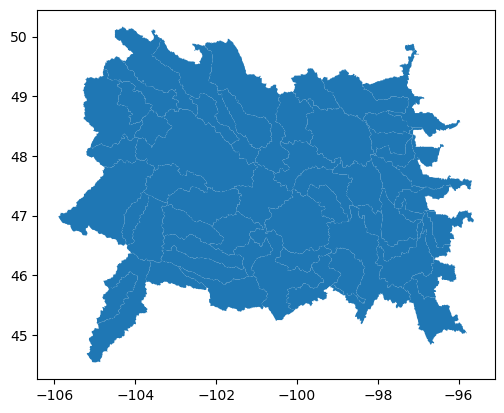

In [26]:
gdf_drb147.plot();

# Export the Output 

In [27]:
outdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   WaDEUUID                        7486 non-null   object
 1   in_MethodUUID                   7486 non-null   object
 2   in_VariableSpecificUUID         7486 non-null   object
 3   in_AggregationIntervalUnitCV    7486 non-null   object
 4   in_VariableCV                   7486 non-null   object
 5   in_VariableSpecificCV           7486 non-null   object
 6   in_OrganizationUUID             7486 non-null   object
 7   in_Geometry                     7486 non-null   object
 8   in_GNISFeatureNameCV            7486 non-null   object
 9   in_WaterQualityIndicatorCV      7486 non-null   object
 10  in_WaterSourceName              7486 non-null   object
 11  in_WaterSourceNativeID          7486 non-null   object
 12  in_WaterSourceTypeCV            7486 non-null   

In [28]:
outdf

,WaDEUUID,in_MethodUUID,in_VariableSpecificUUID,in_AggregationIntervalUnitCV,in_VariableCV,in_VariableSpecificCV,in_OrganizationUUID,in_Geometry,in_GNISFeatureNameCV,in_WaterQualityIndicatorCV,in_WaterSourceName,in_WaterSourceNativeID,in_WaterSourceTypeCV,in_EPSGCodeCV,in_ReportingUnitName,in_ReportingUnitNativeID,in_ReportingUnitProductVersion,in_ReportingUnitTypeCV,in_ReportingUnitUpdateDate,in_StateCV,in_AllocationCropDutyAmount,in_Amount,in_BeneficialUseCategory,in_CommunityWaterSupplySystem,in_CropTypeCV,in_CustomerTypeCV,in_DataPublicationDate,in_DataPublicationDOI,in_InterbasinTransferFromID,in_InterbasinTransferToID,in_IrrigatedAcreage,in_IrrigationMethodCV,in_PopulationServed,in_PowerGeneratedGWh,in_PowerType,in_PrimaryUseCategoryCV,in_ReportYearCV,in_SDWISIdentifierCV,in_TimeframeEnd,in_TimeframeStart
0,drbc1,NDag_M1,NDag_V1,Annual,Withdrawal,Withdrawal_Annual_Domestic_Surface and Groundw...,NDag_O1,,,,,wadeID1,Surface and Groundwater,4326,AppleCreek,nd10130103,,HUC8,,ND,,,Domestic,,,,,,,,0,,,,,,1984,,12/31/1984,01/01/1984
1,drbc2,NDag_M1,NDag_V1,Annual,Withdrawal,Withdrawal_Annual_Domestic_Surface and Groundw...,NDag_O1,,,,,wadeID1,Surface and Groundwater,4326,AppleCreek,nd10130103,,HUC8,,ND,,,Domestic,,,,,,,,0,,,,,,1983,,12/31/1983,01/01/1983
2,drbc3,NDag_M1,NDag_V1,Annual,Withdrawal,Withdrawal_Annual_Domestic_Surface and Groundw...,NDag_O1,,,,,wadeID1,Surface and Groundwater,4326,AppleCreek,nd10130103,,HUC8,,ND,,,Domestic,,,,,,,,0,,,,,,1981,,12/31/1981,01/01/1981
3,drbc4,NDag_M1,NDag_V1,Annual,Withdrawal,Withdrawal_Annual_Domestic_Surface and Groundw...,NDag_O1,,,,,wadeID1,Surface and Groundwater,4326,AppleCreek,nd10130103,,HUC8,,ND,,,Domestic,,,,,,,,0,,,,,,1977,,12/31/1977,01/01/1977
4,drbc6,NDag_M1,NDag_V2,Annual,Withdrawal,Withdrawal_Annual_Fish and Wildlife_Surface an...,NDag_O1,,,,,wadeID1,Surface and Groundwater,4326,AppleCreek,nd10130103,,HUC8,,ND,,0.10000,Fish and Wildlife,,,,,,,,0,,,,,,1990,,12/31/1990,01/01/1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7481,drbc7600,NDag_M1,NDag_V7,Annual,Withdrawal,Withdrawal_Annual_Rural Water_Surface and Grou...,NDag_O1,,,,,wadeID1,Surface and Groundwater,4326,Willow,nd09010004,,HUC8,,ND,,450.30000,Rural Water,,,,,,,,0,,,,,,1984,,12/31/1984,01/01/1984
7482,drbc7601,NDag_M1,NDag_V7,Annual,Withdrawal,Withdrawal_Annual_Rural Water_Surface and Grou...,NDag_O1,,,,,wadeID1,Surface and Groundwater,4326,Willow,nd09010004,,HUC8,,ND,,426.80000,Rural Water,,,,,,,,0,,,,,,1983,,12/31/1983,01/01/1983
7483,drbc7602,NDag_M1,NDag_V7,Annual,Withdrawal,Withdrawal_Annual_Rural Water_Surface and Grou...,NDag_O1,,,,,wadeID1,Surface and Groundwater,4326,Willow,nd09010004,,HUC8,,ND,,7.30000,Rural Water,,,,,,,,0,,,,,,1981,,12/31/1981,01/01/1981
7484,drbc7603,NDag_M1,NDag_V7,Annual,Withdrawal,Withdrawal_Annual_Rural Water_Surface and Grou...,NDag_O1,,,,,wadeID1,Surface and Groundwater,4326,Willow,nd09010004,,HUC8,,ND,,354.60000,Rural Water,,,,,,,,0,,,,,,1980,,12/31/1980,01/01/1980


In [29]:
# Export the output dataframe
outdf.to_csv('RawInputData/Pag_ndMain.zip', compression=dict(method='zip', archive_name='Pag_ndMain.csv'), index=False)   # The output, save as a zip
outshape.to_csv('RawInputData/P_Geometry.zip', compression=dict(method='zip', archive_name='P_Geometry.csv'), index=False)  # The output geometry.